#Install and Import Dependencies

In [75]:
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt
%matplotlib inline

# Compare Facebook Prophet with other existing Forecasting models


*   ARIMA Model
*   SARIMA Model
*   HoltWinters Model

Compare and contrast different performance metrics such as MAE, MSE, RMSE and check best model for given sample data.



In [31]:
import pandas as pd

from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

# read cash flow data
df=pd.read_csv('cashflow.csv')
df.columns = ['time','cashflow']

# convert to TimeSeriesData object
cashflow_ts = TimeSeriesData(df)

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(cashflow_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=13, freq="w")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


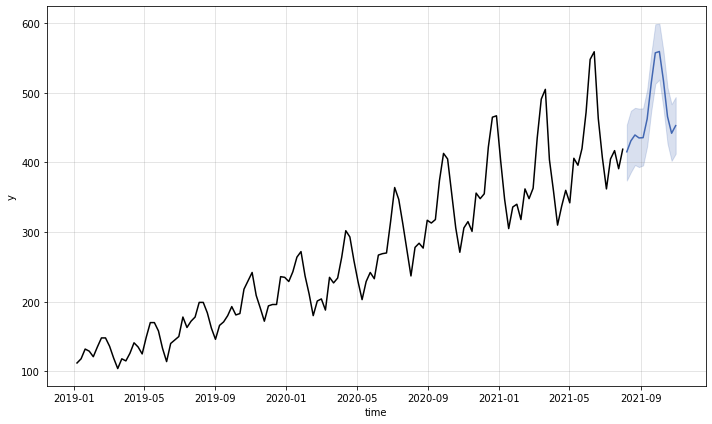

In [32]:
m.plot()

In [33]:
# import packages
import numpy as np

from kats.consts import TimeSeriesData
from kats.detectors.cusum_detection import CUSUMDetector

# run detector and find change points
change_points = CUSUMDetector(cashflow_ts).detector()
change_points

[(TimeSeriesChangePoint(start_time: 2020-06-21 00:00:00, end_time: 2020-06-21 00:00:00, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f3d1898de50>)]

Based on the Change point analysis we see that 21 June 2020 is the time when there was a drastic difference in the cash flow.

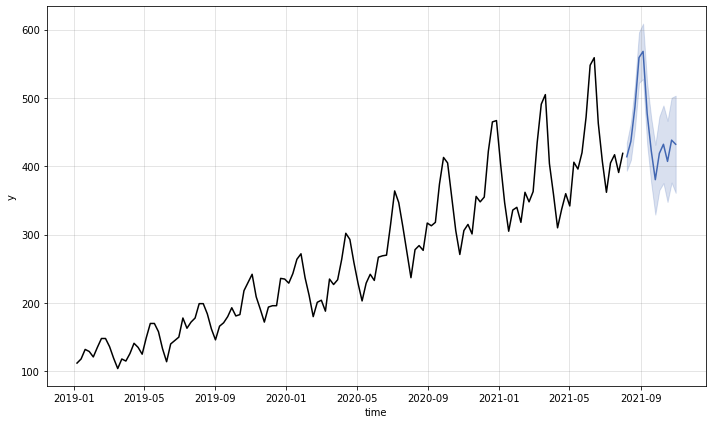

In [34]:
from kats.models.sarima import SARIMAModel, SARIMAParams
import warnings
warnings.simplefilter(action='ignore')

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=cashflow_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=13, 
    freq="w"
    )

# make plot to visualize
m.plot()

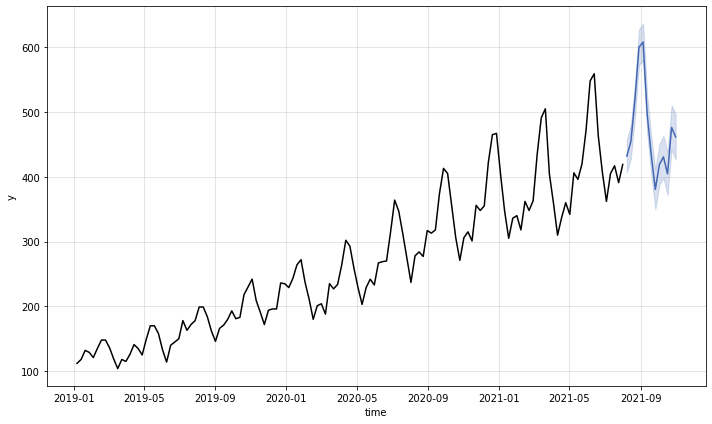

In [35]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
warnings.simplefilter(action='ignore')


params = HoltWintersParams(
            trend="add",
            #damped=False,
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=cashflow_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=13, alpha = 0.1)
m.plot()

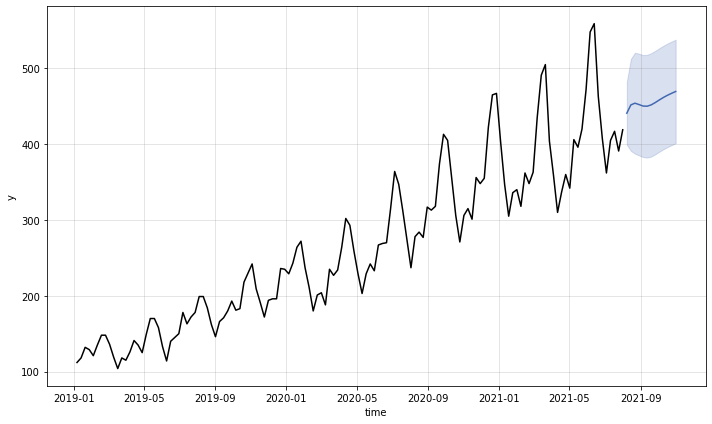

In [36]:
from kats.models.arima import ARIMAModel, ARIMAParams
import warnings
warnings.simplefilter(action='ignore')


params = ARIMAParams(p=2, d=1, q=1)

m = ARIMAModel(
    data=cashflow_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=13, alpha = 0.1)
m.plot()

In [37]:
from kats.utils.backtesters import BackTesterSimple
from kats.models.arima import ARIMAModel, ARIMAParams

backtester_errors = {}

In [38]:
params = ARIMAParams(p=2, d=1, q=1)
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

backtester_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=cashflow_ts,
    params=params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ARIMAModel)

backtester_arima.run_backtest()

backtester_errors['arima'] = {}
for error, value in backtester_arima.errors.items():
    backtester_errors['arima'][error] = value

In [39]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=cashflow_ts,
    params=params_prophet,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()

backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
params_HoltWinters = HoltWintersParams(
            trend="add",
            #damped=False,
            seasonal="mul",
            seasonal_periods=12,
        )

backtester_HoltWinters = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=cashflow_ts,
    params=params_HoltWinters,
    train_percentage=75,
    test_percentage=25, 
    model_class=HoltWintersModel)

backtester_HoltWinters.run_backtest()

backtester_errors['HoltWinters'] = {}
for error, value in backtester_HoltWinters.errors.items():
    backtester_errors['HoltWinters'][error] = value

In [41]:
params_sarima = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

backtester_sarima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=cashflow_ts,
    params=params_sarima,
    train_percentage=75,
    test_percentage=25, 
    model_class=SARIMAModel)

backtester_sarima.run_backtest()

backtester_errors['sarima'] = {}
for error, value in backtester_sarima.errors.items():
    backtester_errors['sarima'][error] = value

In [42]:
pd.DataFrame.from_dict(backtester_errors)

,arima,prophet,HoltWinters,sarima
mape,0.114498,0.116287,0.041913,0.092230
smape,0.121687,0.122985,0.042152,0.087193
mae,49.486569,49.914666,17.265227,35.232883
mase,2.647757,2.670662,0.923768,1.885119
mse,4544.131165,4518.607085,418.830949,1608.653472
rmse,67.410171,67.220585,20.465360,40.108023


## Comparision Results
Based on the backtest results compared by all the models we can see that 
* HoltWinters was performing better and provides lease RMSE value of 20.46 
* ARIMA and Facebook Prophet work closely similar
* SARIMA is capturing sesonality and works better than ARIMA here
* HoltWinters is capturing the trend in the data and performs internal exponential smoothing